In [1]:
# connect ke drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np  # Mengimpor library NumPy untuk manipulasi data numerik.
import tensorflow_datasets as tfds  # Mengimpor TensorFlow Datasets untuk mengakses dataset yang telah disediakan.
import tensorflow as tf  # Mengimpor TensorFlow sebagai library machine learning.

tfds.disable_progress_bar()  # Menonaktifkan progress bar pada TensorFlow Datasets.

In [3]:
import matplotlib.pyplot as plt  # Mengimpor matplotlib.pyplot untuk membuat plot.

# Membuat sebuah fungsi bernama 'plot_graphs' yang akan digunakan untuk menggambar grafik metrik dalam pelatihan model.
def plot_graphs(history, metric):
    plt.plot(history.history[metric])  # Menggambar grafik metrik pelatihan.
    plt.plot(history.history['val_'+metric], '')  # Menggambar grafik metrik validasi (jika tersedia).
    plt.xlabel("Epochs")  # Menambahkan label sumbu x (Epochs).
    plt.ylabel(metric)  # Menambahkan label sumbu y (metric).
    plt.legend([metric, 'val_'+metric])  # Menambahkan legenda untuk grafik.

In [4]:
# Mengambil dataset "imdb_reviews" dari TensorFlow Datasets dan juga mengambil informasi tentang dataset (info).
dataset, info = tfds.load('imdb_reviews', with_info=True, as_supervised=True)

# Memisahkan dataset menjadi dataset pelatihan dan dataset uji.
train_dataset, test_dataset = dataset['train'], dataset['test']

# Menampilkan informasi tentang elemen-elemen dataset pelatihan.
train_dataset.element_spec

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [5]:
# Menggunakan loop untuk mengambil satu contoh dari dataset pelatihan (train_dataset).
for example, label in train_dataset.take(1):
    # Mencetak teks dari contoh dalam format numpy.
    print('text: ', example.numpy())

    # Mencetak label dari contoh dalam format numpy.
    print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


In [6]:
# Menentukan ukuran buffer untuk pengacakan data.
BUFFER_SIZE = 10000

# Menentukan ukuran batch data.
BATCH_SIZE = 64

# Melakukan pengacakan (shuffle) dataset pelatihan, pembagian menjadi batch, dan prefetching.
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Menggunakan loop untuk mengambil satu batch (BATCH_SIZE) dari dataset pelatihan.
for example, label in train_dataset.take(1):
    # Mencetak tiga teks (contoh) pertama dari batch.
    print('texts: ', example.numpy()[:3])
    print()
    # Mencetak tiga label pertama dari batch.
    print('labels: ', label.numpy()[:3])

texts:  [b'This is one of the best Fred Astaire-Ginger Rogers films, or at least one of my favorites. Most of the A-R movies feature great dancing but sappy romance stories. This still has the courtship corniness but not as pronounced as the other films.<br /><br />This movie features not just great dancing but likable characters and a bunch of good songs. The music is the central theme here and what\'s nice is the addition of a tap solo by Rogers. She not only was a super dancer but a very pretty woman and one with tremendous figure. She dances also with Fred, of course, and they\'re always a fun pair to watch on the dance floor.<br /><br />Growing up in the 1950s watching "Ozzie & Harriet" on television, it was a real kick the first time I saw this to see such a young Harriet Hilliard. No surprise than Ozzie fell for this beauty. Although she had that short early \'30s hairstyle, I recognized her voice right away. Also in this movie are quick appearances by Betty Grable and Lucille B

In [7]:
# Menentukan jumlah token maksimum (max_tokens) yang akan digunakan dalam pengkode teks.
VOCAB_SIZE = 1000

# Membuat pengkode teks (TextVectorization) dengan batasan jumlah token.
encoder = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE)

# Mengadaptasi pengkode teks ke dataset pelatihan dengan melakukan pemetaan
# pada fungsi lambda yang mengambil text dan label dari dataset.
encoder.adapt(train_dataset.map(lambda text, label: text))

In [8]:
# Mengambil daftar kata-kata (vocabulary) dari pengkode teks (TextVectorization) yang telah diadaptasi.
vocab = np.array(encoder.get_vocabulary())

# Mencetak 20 kata pertama dari vocabulary.
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

In [9]:
# Mengkodekan (encode) tiga teks (contoh) pertama dari dataset pelatihan
# menggunakan pengkode teks (encoder) dan mengambil hasilnya dalam format numpy.
encoded_example = encoder(example)[:3].numpy()

# Menampilkan hasil pengkodean teks.
encoded_example

array([[ 11,   7,  29, ...,   0,   0,   0],
       [ 10,  26, 180, ...,   0,   0,   0],
       [  1,  13,  10, ...,   0,   0,   0]])

In [10]:
# Mengulang tiga kali untuk tiga contoh (teks)
for n in range(3):
    # Mencetak teks asli
    print("Original: ", example[n].numpy())

    # Menggunakan vocabulary untuk mengembalikan vektor numerik (encoded_example) ke teks
    decoded_text = " ".join(vocab[encoded_example[n]])

    # Mencetak hasil "round-trip", yaitu teks yang telah dikodekan dan dikembalikan
    print("Round-trip: ", decoded_text)

    # Mencetak baris kosong untuk pemisah
    print()

Original:  b'This is one of the best Fred Astaire-Ginger Rogers films, or at least one of my favorites. Most of the A-R movies feature great dancing but sappy romance stories. This still has the courtship corniness but not as pronounced as the other films.<br /><br />This movie features not just great dancing but likable characters and a bunch of good songs. The music is the central theme here and what\'s nice is the addition of a tap solo by Rogers. She not only was a super dancer but a very pretty woman and one with tremendous figure. She dances also with Fred, of course, and they\'re always a fun pair to watch on the dance floor.<br /><br />Growing up in the 1950s watching "Ozzie & Harriet" on television, it was a real kick the first time I saw this to see such a young Harriet Hilliard. No surprise than Ozzie fell for this beauty. Although she had that short early \'30s hairstyle, I recognized her voice right away. Also in this movie are quick appearances by Betty Grable and Lucille

In [11]:
# Membuat model neural network menggunakan tf.keras.Sequential
model = tf.keras.Sequential([
    # Lapisan pengkode teks (encoder) untuk mengkodekan teks menjadi vektor numerik
    encoder,

    # Lapisan embedding dengan 64 output dimension, dan mask_zero=True untuk mengatasi panjang teks yang bervariasi
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),  # Jumlah kata dalam vocabulary
        output_dim=64,  # Dimensi keluaran (output dimension) dari lapisan embedding
        mask_zero=True),  # Menggunakan masking untuk mengatasi teks dengan panjang yang bervariasi

    # Lapisan LSTM dengan 64 unit (neuron) yang bidireksional
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),

    # Lapisan Dense dengan 64 neuron dan fungsi aktivasi ReLU
    tf.keras.layers.Dense(64, activation='relu'),

    # Lapisan Dense dengan 1 neuron (output layer)
    tf.keras.layers.Dense(1)
])

In [12]:
# Menggunakan list comprehension untuk mendapatkan informasi apakah setiap lapisan mendukung masking.
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


In [13]:
# Menyediakan teks sampel yang akan diuji.
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')

# Melakukan prediksi menggunakan model pada teks sampel.
predictions = model.predict(np.array([sample_text]))

# Mencetak hasil prediksi (output model) untuk teks sampel.
print(predictions[0])

1/1 [==============================] - 7s 7s/step
[-0.00042686]


In [14]:
# Membuat teks dengan kata "the" yang diulang sebanyak 2000 kali (sehingga sangat panjang).
padding = "the " * 2000

# Melakukan prediksi menggunakan model pada dua teks: sample_text dan padding.
predictions = model.predict(np.array([sample_text, padding]))

# Mencetak hasil prediksi (output model) untuk dua teks tersebut.
print(predictions[0])

1/1 [==============================] - 0s 83ms/step
[-0.00042686]


In [15]:
# Mengompilasi model neural network dengan pengaturan loss function, optimizer, dan metrik evaluasi.
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),  # Menggunakan loss function BinaryCrossentropy
    optimizer=tf.keras.optimizers.Adam(1e-4),  # Menggunakan optimizer Adam dengan learning rate 1e-4
    metrics=['accuracy']  # Menyertakan metrik akurasi sebagai metrik evaluasi
)

In [16]:
# Melatih model neural network dengan dataset pelatihan.
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 51s 106ms/step - loss: 0.6202 - accuracy: 0.5939 - val_loss: 0.4494 - val_accuracy: 0.7667
Epoch 2/10
391/391 [==============================] - 26s 67ms/step - loss: 0.3837 - accuracy: 0.8249 - val_loss: 0.3615 - val_accuracy: 0.8359
Epoch 3/10
391/391 [==============================] - 26s 65ms/step - loss: 0.3370 - accuracy: 0.8504 - val_loss: 0.3523 - val_accuracy: 0.8333
Epoch 4/10
391/391 [==============================] - 25s 65ms/step - loss: 0.3188 - accuracy: 0.8618 - val_loss: 0.3393 - val_accuracy: 0.8521
Epoch 5/10
391/391 [==============================] - 26s 66ms/step - loss: 0.3101 - accuracy: 0.8635 - val_loss: 0.3273 - val_accuracy: 0.8526
Epoch 6/10
391/391 [==============================] - 24s 62ms/step - loss: 0.3071 - accuracy: 0.8679 - val_loss: 0.3397 - val_accuracy: 0.8536
Epoch 7/10
391/391 [==============================] - 26s 65ms/step - loss: 0.3058 - accuracy: 0.8670 - val_loss: 0.3258 - val_accuracy

In [17]:
# Menggunakan model untuk mengevaluasi dataset uji (test_dataset).
test_loss, test_acc = model.evaluate(test_dataset)

# Mencetak hasil evaluasi, yaitu loss dan akurasi pada dataset uji.
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 11s 29ms/step - loss: 0.3162 - accuracy: 0.8539
Test Loss: 0.3162204623222351
Test Accuracy: 0.853879988193512


(0.0, 0.6361771389842034)

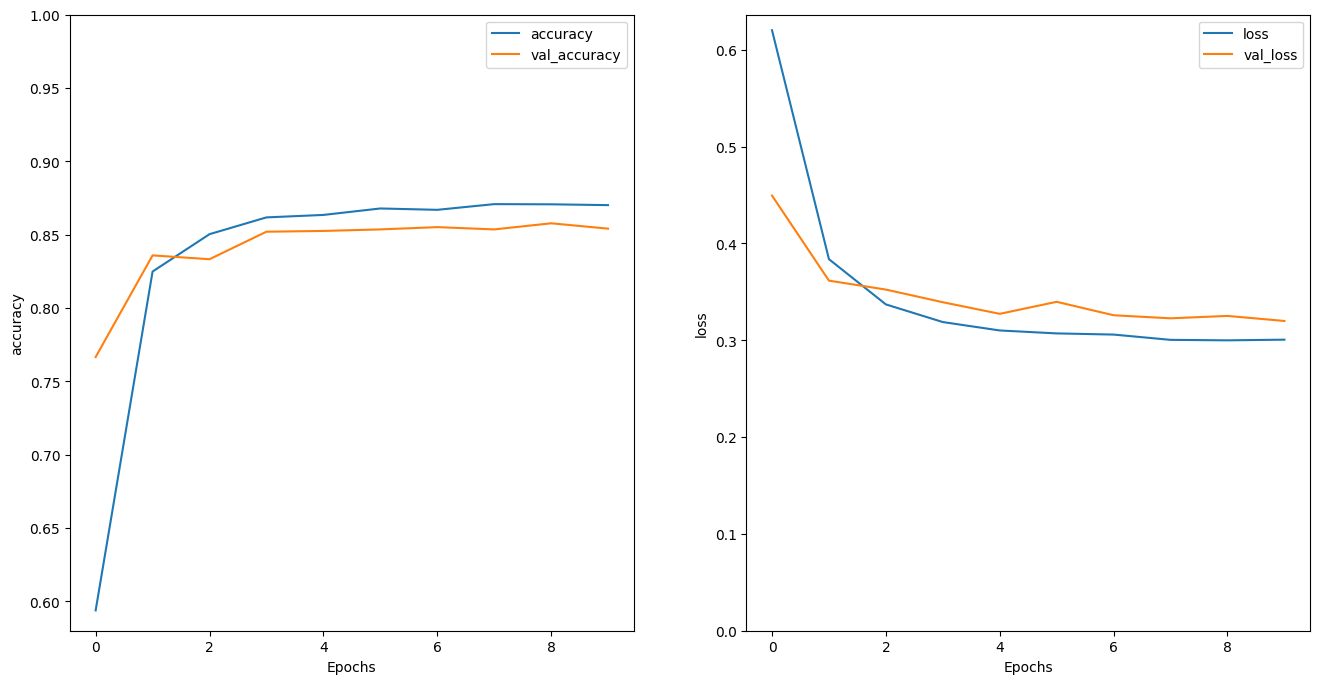

In [18]:
# Membuat sebuah gambar (figure) dengan ukuran 16x8
plt.figure(figsize=(16, 8))

# Membagi gambar menjadi dua subplot (1 baris, 2 kolom), yang pertama adalah untuk akurasi dan yang kedua untuk loss.

# Subplot untuk akurasi
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')  # Menggunakan fungsi plot_graphs untuk menggambar grafik akurasi
plt.ylim(None, 1)  # Mengatur batas sumbu y untuk akurasi

# Subplot untuk loss
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')  # Menggunakan fungsi plot_graphs untuk menggambar grafik loss
plt.ylim(0, None)  # Mengatur batas sumbu y untuk loss

In [19]:
# Menyediakan teks sampel yang akan diuji.
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')

# Melakukan prediksi menggunakan model pada teks sampel.
predictions = model.predict(np.array([sample_text]))

1/1 [==============================] - 3s 3s/step


In [20]:
# Membuat model neural network menggunakan tf.keras.Sequential
model = tf.keras.Sequential([
    # Lapisan pengkode teks (encoder) untuk mengkodekan teks menjadi vektor numerik
    encoder,

    # Lapisan embedding dengan 64 output dimension, dan mask_zero=True untuk mengatasi panjang teks yang bervariasi
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),

    # Lapisan LSTM bidireksional dengan 64 unit (neuron) yang mengembalikan semua urutan (return_sequences=True)
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),

    # Lapisan LSTM bidireksional dengan 32 unit (neuron)
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),

    # Lapisan Dense dengan 64 neuron dan fungsi aktivasi ReLU
    tf.keras.layers.Dense(64, activation='relu'),

    # Lapisan dropout dengan tingkat dropout 0.5
    tf.keras.layers.Dropout(0.5),

    # Lapisan Dense dengan 1 neuron (output layer)
    tf.keras.layers.Dense(1)
])

In [21]:
# Mengompilasi model neural network dengan pengaturan loss function, optimizer, dan metrik evaluasi.
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),  # Menggunakan loss function BinaryCrossentropy
    optimizer=tf.keras.optimizers.Adam(1e-4),  # Menggunakan optimizer Adam dengan learning rate 1e-4
    metrics=['accuracy']  # Menyertakan metrik akurasi sebagai metrik evaluasi
)

In [22]:
# Melatih model neural network dengan dataset pelatihan.
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 79s 157ms/step - loss: 0.6167 - accuracy: 0.5963 - val_loss: 0.4318 - val_accuracy: 0.7875
Epoch 2/10
391/391 [==============================] - 49s 124ms/step - loss: 0.3774 - accuracy: 0.8353 - val_loss: 0.3557 - val_accuracy: 0.8354
Epoch 3/10
391/391 [==============================] - 48s 121ms/step - loss: 0.3327 - accuracy: 0.8570 - val_loss: 0.3301 - val_accuracy: 0.8495
Epoch 4/10
391/391 [==============================] - 55s 141ms/step - loss: 0.3161 - accuracy: 0.8661 - val_loss: 0.3325 - val_accuracy: 0.8578
Epoch 5/10
391/391 [==============================] - 46s 118ms/step - loss: 0.3130 - accuracy: 0.8663 - val_loss: 0.3315 - val_accuracy: 0.8573
Epoch 6/10
391/391 [==============================] - 48s 122ms/step - loss: 0.3062 - accuracy: 0.8690 - val_loss: 0.3211 - val_accuracy: 0.8599
Epoch 7/10
391/391 [==============================] - 47s 120ms/step - loss: 0.3022 - accuracy: 0.8702 - val_loss: 0.3186 - val_ac

In [23]:
# Menggunakan model untuk mengevaluasi dataset uji (test_dataset).
test_loss, test_acc = model.evaluate(test_dataset)

# Mencetak hasil evaluasi, yaitu loss dan akurasi pada dataset uji.
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 20s 50ms/step - loss: 0.3153 - accuracy: 0.8589
Test Loss: 0.315308153629303
Test Accuracy: 0.8589199781417847


In [24]:
# Menyediakan teks sampel yang akan diuji.
sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')

# Melakukan prediksi menggunakan model pada teks sampel.
predictions = model.predict(np.array([sample_text]))

# Mencetak hasil prediksi untuk teks sampel.
print(predictions)

1/1 [==============================] - 5s 5s/step
[[-2.1052525]]


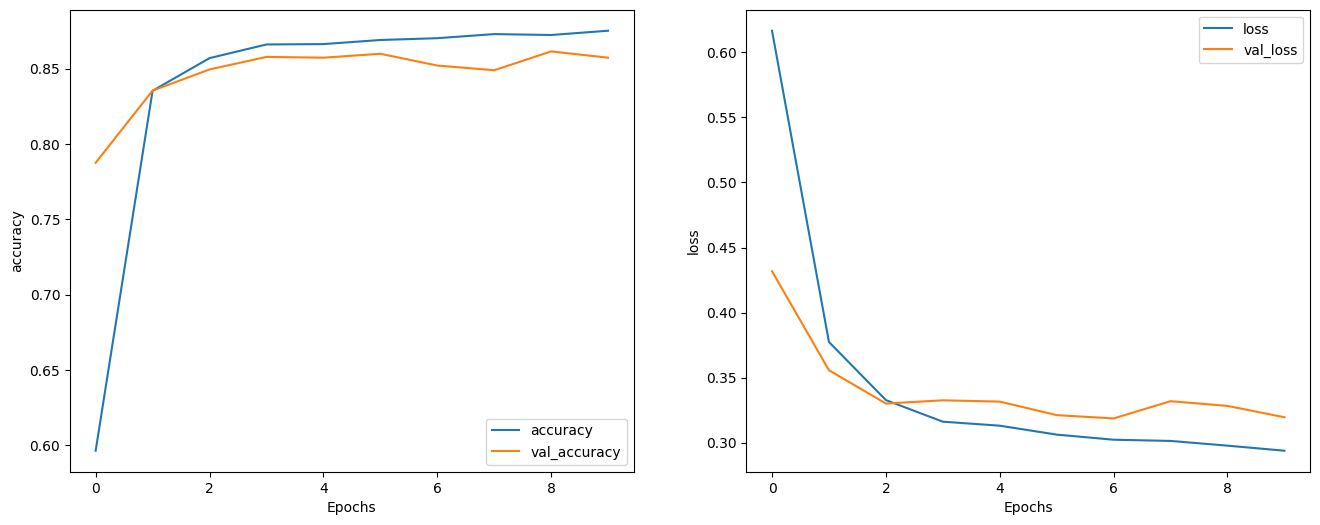

In [25]:
# Membuat sebuah gambar (figure) dengan ukuran 16x6
plt.figure(figsize=(16, 6))

# Membagi gambar menjadi dua subplot (1 baris, 2 kolom), yang pertama adalah untuk akurasi dan yang kedua untuk loss.

# Subplot untuk akurasi
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')  # Menggunakan fungsi plot_graphs untuk menggambar grafik akurasi

# Subplot untuk loss
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')  # Menggunakan fungsi plot_graphs untuk menggambar grafik loss